In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import sys
import warnings
import math
import json
import requests


import optuna
from optuna.samplers import TPESampler
from matplotlib import pyplot as plt
from sklearn import datasets as dat
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import preprocessing as pre
from sklearn import base
from sklearn import impute as imp
from sklearn import ensemble as ens
from sklearn import compose as com
from sklearn import metrics as met
from sklearn import feature_selection as fea
from sklearn import tree
from sklearn import linear_model as lin
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats
from sklearn import cluster as clu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost.sklearn as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.graphics.gofplots import qqplot
# DAY OR NIGHT
from astral.sun import sun
from astral import LocationInfo

warnings.filterwarnings("ignore", category=UserWarning)
sys.path.append('../../../')


pd.options.plotting.backend = "plotly"
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
import datetime
import pickle
import sqlalchemy as sa

# For Statistical
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from lofo import LOFOImportance, Dataset, plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error,make_scorer
from sklearn.model_selection import GridSearchCV

In [3]:
stores= pd.read_csv("stores.csv")
oil=pd.read_csv("oil.csv")
transactions=pd.read_csv("transactions.csv")
holidays_events=pd.read_csv("holidays_events.csv")
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
df['date'] = pd.to_datetime(df['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])

df['date'] = pd.to_datetime(df['date'])
df['store_nbr'] = df['store_nbr'].astype(int)
df['family'] = df['family'].astype(str)
df['sales'] = df['sales'].astype(int)
df['onpromotion'] = df['onpromotion'].astype(int)

merged_df = pd.merge(df, stores, on='store_nbr', how='left')
merged_df = pd.merge(merged_df, oil, on='date', how='left')
merged_df = pd.merge(merged_df, transactions, on=['date', 'store_nbr'], how='left')
merged_df = merged_df.sort_values(by='date', ascending=False)

merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.drop(columns=['id'])
df=merged_df

In [4]:
df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,2017-08-15,9,SEAFOOD,16,0,Quito,Pichincha,B,6,47.57,2155.0
1,2017-08-15,26,BEVERAGES,762,10,Guayaquil,Guayas,D,10,47.57,534.0
2,2017-08-15,25,PERSONAL CARE,93,8,Salinas,Santa Elena,D,1,47.57,849.0
3,2017-08-15,25,PET SUPPLIES,3,0,Salinas,Santa Elena,D,1,47.57,849.0
4,2017-08-15,25,PLAYERS AND ELECTRONICS,3,0,Salinas,Santa Elena,D,1,47.57,849.0


In [5]:
food_and_beverage_categories = [
    'SEAFOOD', 'BEVERAGES', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
    'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'MEATS',
    'LIQUOR,WINE,BEER'
]

household_and_cleaning_categories = ['PERSONAL CARE', 'CLEANING', 'HOME CARE', 'LAWN AND GARDEN']

electronics_and_appliances_categories = ['PLAYERS AND ELECTRONICS', 'HOME APPLIANCES', 'HARDWARE']

apparel_and_personal_items_categories = ['BABY CARE', 'BEAUTY', 'LINGERIE', 'LADIESWEAR']

home_and_office_supplies_categories = ['SCHOOL AND OFFICE SUPPLIES', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CELEBRATION']

miscellaneous_categories = ['PET SUPPLIES', 'AUTOMOTIVE', 'BOOKS', 'MAGAZINES', 'GROCERY I', 'GROCERY II']

# Create a new column 'group' based on the conditions
df['group'] = df['family'].apply(lambda x: 
                                 'food and beverage' if x in food_and_beverage_categories 
                                 else ('household and cleaning' if x in household_and_cleaning_categories 
                                       else ('electronics and appliances' if x in electronics_and_appliances_categories 
                                             else ('apparel and personal items' if x in apparel_and_personal_items_categories 
                                                   else ('home and office supplies' if x in home_and_office_supplies_categories 
                                                         else ('miscellaneous' if x in miscellaneous_categories 
                                                               else 0))))))

In [6]:
df['group'].unique()

array(['food and beverage', 'household and cleaning', 'miscellaneous',
       'electronics and appliances', 'home and office supplies',
       'apparel and personal items'], dtype=object)

In [7]:
df = df.drop(['family'], axis=1)

In [8]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances


In [9]:
df.describe()

,date,store_nbr,sales,onpromotion,cluster,dcoilwtico,transactions
count,3000888,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06,2.072466e+06,2.755104e+06
mean,2015-04-24 08:27:04.703087360,2.750000e+01,3.576988e+02,2.602770e+00,8.481481e+00,6.792559e+01,1.694602e+03
min,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.619000e+01,5.000000e+00
25%,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.638000e+01,1.046000e+03
50%,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00,8.500000e+00,5.333000e+01,1.393000e+03
75%,2016-06-19 06:00:00,4.100000e+01,1.950000e+02,0.000000e+00,1.300000e+01,9.580000e+01,2.079000e+03
max,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02,1.700000e+01,1.106200e+02,8.359000e+03
std,NaN,1.558579e+01,1.101976e+03,1.221888e+01,4.649735e+00,2.566633e+01,9.632810e+02


In [10]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances


In [11]:
df['DayOfWeek'] = df['date'].dt.dayofweek
df['date'] = pd.to_datetime(df['date'])
df['Week'] = df['date'].dt.isocalendar().week
df['Month'] = df['date'].dt.month
df["Quarter"] = df["date"].dt.quarter
df["Year"] = df["date"].dt.year
#df["WeekOfYear"] = df["date"].dt.isocalendar().weekofyear

In [12]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group,DayOfWeek,Week,Month,Quarter,Year
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage,1,33,8,3,2017
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage,1,33,8,3,2017
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning,1,33,8,3,2017
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous,1,33,8,3,2017
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances,1,33,8,3,2017


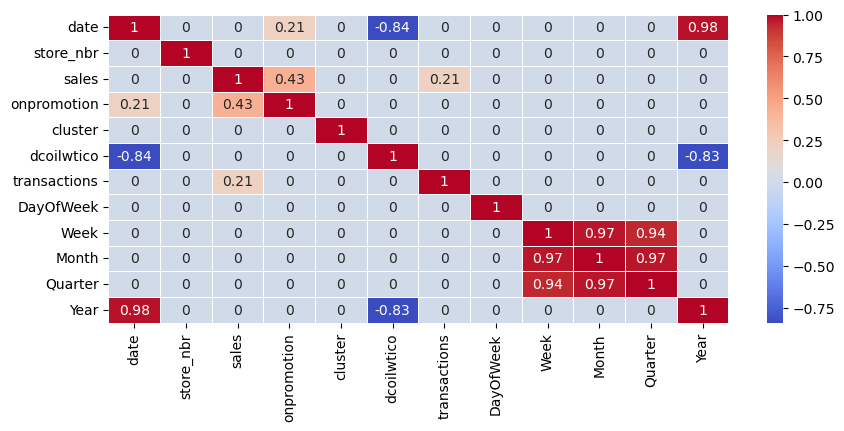

In [13]:
corr = df.select_dtypes(exclude="object").corr()
high_corr = corr[abs(corr) > 0.2].fillna(0)
plt.figure(figsize=(10, 4))
sns.heatmap(high_corr, cmap='coolwarm', annot=True, linewidths=.5)
plt.show()

In [14]:
def cycle_encode(data, cols):
    for col in cols:
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
    return data

In [15]:
"""def time_feat_exct(df):
    df["date"] = pd.to_datetime(df["date"])
    df["start_dow_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)
    df["start_dow_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)

    df['start_week_cos'] = np.cos(2 * np.pi * df["Week"] / 51.0).astype(int)
    df['start_week_sin'] = np.sin(2 * np.pi * df["Week"] / 51.0).astype(int)

    df['start_month_cos'] = np.cos(2 * np.pi * df["Month"] / 12.0).astype(int)
    df['start_month_sin'] = np.sin(2 * np.pi * df["Month"] / 12.0).astype(int)
    return df"""

'def time_feat_exct(df):\n    df["date"] = pd.to_datetime(df["date"])\n    df["start_dow_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)\n    df["start_dow_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 6.0).astype(int)\n\n    df[\'start_week_cos\'] = np.cos(2 * np.pi * df["Week"] / 51.0).astype(int)\n    df[\'start_week_sin\'] = np.sin(2 * np.pi * df["Week"] / 51.0).astype(int)\n\n    df[\'start_month_cos\'] = np.cos(2 * np.pi * df["Month"] / 12.0).astype(int)\n    df[\'start_month_sin\'] = np.sin(2 * np.pi * df["Month"] / 12.0).astype(int)\n    return df'

In [16]:
df = cycle_encode(df, ["DayOfWeek", "Week", "Quarter"])

In [17]:
df.head()

,date,store_nbr,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions,group,DayOfWeek,Week,Month,Quarter,Year,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Quarter_sin,Quarter_cos
0,2017-08-15,9,16,0,Quito,Pichincha,B,6,47.57,2155.0,food and beverage,1,33,8,3,2017,0.866025,0.5,-0.696551,-0.717507,-1.0,-1.836970e-16
1,2017-08-15,26,762,10,Guayaquil,Guayas,D,10,47.57,534.0,food and beverage,1,33,8,3,2017,0.866025,0.5,-0.696551,-0.717507,-1.0,-1.836970e-16
2,2017-08-15,25,93,8,Salinas,Santa Elena,D,1,47.57,849.0,household and cleaning,1,33,8,3,2017,0.866025,0.5,-0.696551,-0.717507,-1.0,-1.836970e-16
3,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,miscellaneous,1,33,8,3,2017,0.866025,0.5,-0.696551,-0.717507,-1.0,-1.836970e-16
4,2017-08-15,25,3,0,Salinas,Santa Elena,D,1,47.57,849.0,electronics and appliances,1,33,8,3,2017,0.866025,0.5,-0.696551,-0.717507,-1.0,-1.836970e-16


In [19]:
df.drop(["DayOfWeek", "Week", "Quarter"], axis=1, inplace=True)

In [18]:
df = df.drop(['date'], axis=1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column         Dtype  
---  ------         -----  
 0   store_nbr      int64  
 1   sales          int64  
 2   onpromotion    int64  
 3   city           object 
 4   state          object 
 5   type           object 
 6   cluster        int64  
 7   dcoilwtico     float64
 8   transactions   float64
 9   group          object 
 10  Month          int32  
 11  Year           int32  
 12  DayOfWeek_sin  float64
 13  DayOfWeek_cos  float64
 14  Week_sin       Float64
 15  Week_cos       Float64
 16  Quarter_sin    float64
 17  Quarter_cos    float64
dtypes: Float64(2), float64(6), int32(2), int64(4), object(4)
memory usage: 394.9+ MB


In [21]:
"""phrase_cols = [col for col in df.columns if "temperature" in col]

# Lagged
for i in [1, 2, 3, 23, 24]:
    for col in phrase_cols:
        df[col + "_{}h_lagged".format(i)] = df[col].shift(i)"""

'phrase_cols = [col for col in df.columns if "temperature" in col]\n\n# Lagged\nfor i in [1, 2, 3, 23, 24]:\n    for col in phrase_cols:\n        df[col + "_{}h_lagged".format(i)] = df[col].shift(i)'

In [22]:
"""# Lead
phrase_cols = [col for col in df.columns if
               "temperature" in col or "wxPhraseLong" in col or "UvIndex" in col]
for i in [1, 2, 3, 4]:
    for col in phrase_cols:
        df[col + "_{}h_lead".format(i)] = df[col].shift(-i)"""

'# Lead\nphrase_cols = [col for col in df.columns if\n               "temperature" in col or "wxPhraseLong" in col or "UvIndex" in col]\nfor i in [1, 2, 3, 4]:\n    for col in phrase_cols:\n        df[col + "_{}h_lead".format(i)] = df[col].shift(-i)'

In [23]:
df.isnull().sum()

store_nbr             0
sales                 0
onpromotion           0
city                  0
state                 0
type                  0
cluster               0
dcoilwtico       928422
transactions     245784
group                 0
Month                 0
Year                  0
DayOfWeek_sin         0
DayOfWeek_cos         0
Week_sin              0
Week_cos              0
Quarter_sin           0
Quarter_cos           0
dtype: int64

In [24]:
df['store_nbr'] = df['store_nbr'].astype('object')

In [25]:
df.drop('transactions', axis=1, inplace=True)

In [26]:
cat_columns = list(df.select_dtypes(include="object").columns)
cat_columns

['store_nbr', 'city', 'state', 'type', 'group']

In [27]:
num_columns = list(df.select_dtypes(exclude = "object").columns[3:])
num_columns

['dcoilwtico',
 'Month',
 'Year',
 'DayOfWeek_sin',
 'DayOfWeek_cos',
 'Week_sin',
 'Week_cos',
 'Quarter_sin',
 'Quarter_cos']

In [28]:
X = df.drop('sales', axis=1)
y = df['sales']

In [29]:
X_train, X_test, y_train, y_test = mod.train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2010594, 16)
(990294, 16)
(2010594,)
(990294,)


In [26]:
"""fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=X_train, x='Month', y=y_train, palette='Blues')
ax.set_title('MW by Month')
plt.show()"""

"fig, ax = plt.subplots(figsize=(8, 5))\nsns.boxplot(data=X_train, x='Month', y=y_train, palette='Blues')\nax.set_title('MW by Month')\nplt.show()"

In [31]:
pipe_num = pip.Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", pre.StandardScaler()),
])


pipe_cat = pip.Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("enc", pre.OneHotEncoder(handle_unknown="ignore")),
])

ct = com.ColumnTransformer([
    ('num', pipe_num, num_columns),
    ('cat', pipe_cat, cat_columns)
])

pip_final = pip.Pipeline([
    ('ct', ct),
    ('model', CatBoostRegressor())
])

params = {
    'model__learning_rate': [0.03, 0.1],
    'model__n_estimators' : [100,148,200],
    'model__max_depth' : [6,10,20]
}


def rmsle(y_true,y_pred):
    return np.sqrt(mean_squared_log_error(y_true,y_pred))

rsmles_scorer=make_scorer(rmsle,greater_is_better=False)

grid = GridSearchCV(pip_final,
                    param_grid = params,
                    scoring = rsmles_scorer,
                    cv = TimeSeriesSplit(n_splits=3),
                   )


In [33]:
grid.fit(X, y)

0:	learn: 1318.7527292	total: 28.4ms	remaining: 2.81s
1:	learn: 1314.1587080	total: 55.3ms	remaining: 2.71s
2:	learn: 1309.8214363	total: 87.5ms	remaining: 2.83s
3:	learn: 1305.7562560	total: 115ms	remaining: 2.75s
4:	learn: 1301.8910825	total: 141ms	remaining: 2.68s
5:	learn: 1298.2437957	total: 168ms	remaining: 2.63s
6:	learn: 1294.8026472	total: 194ms	remaining: 2.58s
7:	learn: 1291.5564656	total: 224ms	remaining: 2.58s
8:	learn: 1288.5186977	total: 256ms	remaining: 2.58s
9:	learn: 1285.6538784	total: 284ms	remaining: 2.55s
10:	learn: 1282.9290631	total: 320ms	remaining: 2.59s
11:	learn: 1280.3599631	total: 348ms	remaining: 2.55s
12:	learn: 1277.9202172	total: 376ms	remaining: 2.52s
13:	learn: 1275.6458027	total: 404ms	remaining: 2.48s
14:	learn: 1273.4724251	total: 436ms	remaining: 2.47s
15:	learn: 1271.4220091	total: 470ms	remaining: 2.47s
16:	learn: 1269.4897281	total: 500ms	remaining: 2.44s
17:	learn: 1267.6551516	total: 528ms	remaining: 2.41s
18:	learn: 1265.9833542	total: 559m

55:	learn: 1198.6107861	total: 2.75s	remaining: 2.16s
56:	learn: 1198.2708996	total: 2.8s	remaining: 2.11s
57:	learn: 1197.9896075	total: 2.84s	remaining: 2.06s
58:	learn: 1197.7078796	total: 2.89s	remaining: 2.01s
59:	learn: 1197.4498283	total: 2.94s	remaining: 1.96s
60:	learn: 1197.2040989	total: 2.98s	remaining: 1.91s
61:	learn: 1196.9522659	total: 3.03s	remaining: 1.85s
62:	learn: 1196.7195875	total: 3.07s	remaining: 1.8s
63:	learn: 1196.4983778	total: 3.12s	remaining: 1.75s
64:	learn: 1196.2488195	total: 3.16s	remaining: 1.7s
65:	learn: 1196.0443689	total: 3.2s	remaining: 1.65s
66:	learn: 1195.8500583	total: 3.25s	remaining: 1.6s
67:	learn: 1195.6660743	total: 3.3s	remaining: 1.55s
68:	learn: 1195.4731510	total: 3.35s	remaining: 1.5s
69:	learn: 1195.2571998	total: 3.4s	remaining: 1.46s
70:	learn: 1195.0844254	total: 3.44s	remaining: 1.41s
71:	learn: 1194.9120807	total: 3.49s	remaining: 1.36s
72:	learn: 1194.7361228	total: 3.53s	remaining: 1.31s
73:	learn: 1194.5672615	total: 3.58s

15:	learn: 1271.4220091	total: 466ms	remaining: 3.84s
16:	learn: 1269.4897281	total: 500ms	remaining: 3.85s
17:	learn: 1267.6551516	total: 534ms	remaining: 3.86s
18:	learn: 1265.9833542	total: 567ms	remaining: 3.85s
19:	learn: 1264.3175487	total: 602ms	remaining: 3.85s
20:	learn: 1262.7652344	total: 636ms	remaining: 3.85s
21:	learn: 1261.3052509	total: 668ms	remaining: 3.82s
22:	learn: 1259.8984953	total: 699ms	remaining: 3.8s
23:	learn: 1258.5521235	total: 730ms	remaining: 3.77s
24:	learn: 1257.2955702	total: 760ms	remaining: 3.74s
25:	learn: 1256.0945698	total: 790ms	remaining: 3.71s
26:	learn: 1254.9456702	total: 817ms	remaining: 3.66s
27:	learn: 1253.8482396	total: 840ms	remaining: 3.6s
28:	learn: 1252.8107423	total: 865ms	remaining: 3.55s
29:	learn: 1251.8379501	total: 892ms	remaining: 3.51s
30:	learn: 1250.9063360	total: 918ms	remaining: 3.46s
31:	learn: 1250.0117348	total: 944ms	remaining: 3.42s
32:	learn: 1249.1444494	total: 969ms	remaining: 3.38s
33:	learn: 1248.2938406	total:

20:	learn: 1223.1364875	total: 953ms	remaining: 5.76s
21:	learn: 1221.6991032	total: 995ms	remaining: 5.7s
22:	learn: 1220.3994041	total: 1.04s	remaining: 5.66s
23:	learn: 1219.1302898	total: 1.09s	remaining: 5.61s
24:	learn: 1217.9213054	total: 1.14s	remaining: 5.63s
25:	learn: 1216.7763534	total: 1.19s	remaining: 5.58s
26:	learn: 1215.6645499	total: 1.23s	remaining: 5.53s
27:	learn: 1214.6387693	total: 1.28s	remaining: 5.49s
28:	learn: 1213.6700726	total: 1.33s	remaining: 5.44s
29:	learn: 1212.7054105	total: 1.37s	remaining: 5.39s
30:	learn: 1211.8010656	total: 1.42s	remaining: 5.34s
31:	learn: 1210.9533659	total: 1.47s	remaining: 5.31s
32:	learn: 1210.1016488	total: 1.51s	remaining: 5.27s
33:	learn: 1209.3157128	total: 1.56s	remaining: 5.23s
34:	learn: 1208.5773414	total: 1.61s	remaining: 5.2s
35:	learn: 1207.8695673	total: 1.67s	remaining: 5.18s
36:	learn: 1207.1955803	total: 1.72s	remaining: 5.15s
37:	learn: 1206.5656319	total: 1.76s	remaining: 5.11s
38:	learn: 1205.9162773	total:

25:	learn: 1132.4468876	total: 1.87s	remaining: 8.76s
26:	learn: 1131.4307218	total: 1.94s	remaining: 8.7s
27:	learn: 1130.4244163	total: 2.01s	remaining: 8.61s
28:	learn: 1129.4767554	total: 2.08s	remaining: 8.52s
29:	learn: 1128.5829820	total: 2.14s	remaining: 8.42s
30:	learn: 1127.7308690	total: 2.21s	remaining: 8.34s
31:	learn: 1126.9084421	total: 2.27s	remaining: 8.23s
32:	learn: 1126.1365776	total: 2.34s	remaining: 8.15s
33:	learn: 1125.3872678	total: 2.41s	remaining: 8.07s
34:	learn: 1124.6741067	total: 2.47s	remaining: 7.97s
35:	learn: 1123.9869091	total: 2.54s	remaining: 7.9s
36:	learn: 1123.3399345	total: 2.61s	remaining: 7.83s
37:	learn: 1122.7108206	total: 2.67s	remaining: 7.73s
38:	learn: 1122.1171115	total: 2.74s	remaining: 7.65s
39:	learn: 1121.5596556	total: 2.81s	remaining: 7.59s
40:	learn: 1120.9928108	total: 2.87s	remaining: 7.5s
41:	learn: 1120.4792735	total: 2.94s	remaining: 7.43s
42:	learn: 1119.9743722	total: 3s	remaining: 7.34s
43:	learn: 1119.5055543	total: 3.0

32:	learn: 1249.1444494	total: 862ms	remaining: 4.36s
33:	learn: 1248.2938406	total: 888ms	remaining: 4.34s
34:	learn: 1247.5279796	total: 916ms	remaining: 4.32s
35:	learn: 1246.7707466	total: 940ms	remaining: 4.28s
36:	learn: 1246.0741593	total: 968ms	remaining: 4.26s
37:	learn: 1245.3946094	total: 995ms	remaining: 4.24s
38:	learn: 1244.7467642	total: 1.02s	remaining: 4.22s
39:	learn: 1244.1287627	total: 1.05s	remaining: 4.2s
40:	learn: 1243.5263721	total: 1.07s	remaining: 4.17s
41:	learn: 1242.9464101	total: 1.1s	remaining: 4.14s
42:	learn: 1242.3934615	total: 1.13s	remaining: 4.11s
43:	learn: 1241.8688112	total: 1.15s	remaining: 4.08s
44:	learn: 1241.3670930	total: 1.18s	remaining: 4.05s
45:	learn: 1240.8499608	total: 1.2s	remaining: 4.03s
46:	learn: 1240.3885444	total: 1.23s	remaining: 4s
47:	learn: 1239.9570678	total: 1.25s	remaining: 3.97s
48:	learn: 1239.5326445	total: 1.28s	remaining: 3.94s
49:	learn: 1239.0581270	total: 1.31s	remaining: 3.92s
50:	learn: 1238.6503252	total: 1.3

189:	learn: 1223.0317790	total: 4.65s	remaining: 245ms
190:	learn: 1222.9660582	total: 4.67s	remaining: 220ms
191:	learn: 1222.9268874	total: 4.7s	remaining: 196ms
192:	learn: 1222.8915644	total: 4.72s	remaining: 171ms
193:	learn: 1222.8477786	total: 4.74s	remaining: 147ms
194:	learn: 1222.8191242	total: 4.77s	remaining: 122ms
195:	learn: 1222.7923960	total: 4.79s	remaining: 97.8ms
196:	learn: 1222.7555176	total: 4.81s	remaining: 73.3ms
197:	learn: 1222.7098589	total: 4.83s	remaining: 48.8ms
198:	learn: 1222.6548556	total: 4.86s	remaining: 24.4ms
199:	learn: 1222.6225962	total: 4.88s	remaining: 0us
0:	learn: 1276.6023971	total: 48.2ms	remaining: 9.58s
1:	learn: 1272.2605074	total: 93.8ms	remaining: 9.28s
2:	learn: 1268.1616283	total: 138ms	remaining: 9.03s
3:	learn: 1264.2602122	total: 182ms	remaining: 8.92s
4:	learn: 1260.5783253	total: 228ms	remaining: 8.9s
5:	learn: 1257.1341135	total: 274ms	remaining: 8.86s
6:	learn: 1253.8552385	total: 319ms	remaining: 8.81s
7:	learn: 1250.7997258

142:	learn: 1187.4421301	total: 6.27s	remaining: 2.5s
143:	learn: 1187.3709155	total: 6.31s	remaining: 2.45s
144:	learn: 1187.3192039	total: 6.35s	remaining: 2.41s
145:	learn: 1187.2645612	total: 6.38s	remaining: 2.36s
146:	learn: 1187.2141395	total: 6.42s	remaining: 2.31s
147:	learn: 1187.1406632	total: 6.47s	remaining: 2.27s
148:	learn: 1187.0587062	total: 6.51s	remaining: 2.23s
149:	learn: 1186.9804720	total: 6.55s	remaining: 2.18s
150:	learn: 1186.9217834	total: 6.6s	remaining: 2.14s
151:	learn: 1186.8731340	total: 6.64s	remaining: 2.1s
152:	learn: 1186.8127623	total: 6.68s	remaining: 2.05s
153:	learn: 1186.7558752	total: 6.72s	remaining: 2.01s
154:	learn: 1186.7124776	total: 6.76s	remaining: 1.96s
155:	learn: 1186.6540303	total: 6.81s	remaining: 1.92s
156:	learn: 1186.6026801	total: 6.85s	remaining: 1.88s
157:	learn: 1186.5558657	total: 6.89s	remaining: 1.83s
158:	learn: 1186.5173763	total: 6.93s	remaining: 1.79s
159:	learn: 1186.4597089	total: 6.97s	remaining: 1.74s
160:	learn: 1

96:	learn: 1107.0094867	total: 7.32s	remaining: 7.78s
97:	learn: 1106.9073129	total: 7.39s	remaining: 7.69s
98:	learn: 1106.7955146	total: 7.46s	remaining: 7.61s
99:	learn: 1106.6647239	total: 7.52s	remaining: 7.52s
100:	learn: 1106.5801161	total: 7.58s	remaining: 7.42s
101:	learn: 1106.4725978	total: 7.63s	remaining: 7.33s
102:	learn: 1106.3803265	total: 7.69s	remaining: 7.24s
103:	learn: 1106.2901911	total: 7.76s	remaining: 7.16s
104:	learn: 1106.2003973	total: 7.81s	remaining: 7.07s
105:	learn: 1106.1214371	total: 7.87s	remaining: 6.98s
106:	learn: 1106.0249145	total: 7.93s	remaining: 6.89s
107:	learn: 1105.9458032	total: 7.99s	remaining: 6.8s
108:	learn: 1105.8382840	total: 8.04s	remaining: 6.72s
109:	learn: 1105.7506851	total: 8.11s	remaining: 6.63s
110:	learn: 1105.6435602	total: 8.18s	remaining: 6.56s
111:	learn: 1105.5379870	total: 8.25s	remaining: 6.48s
112:	learn: 1105.4471971	total: 8.31s	remaining: 6.4s
113:	learn: 1105.3438469	total: 8.38s	remaining: 6.33s
114:	learn: 1105

48:	learn: 1230.9164365	total: 3.04s	remaining: 3.16s
49:	learn: 1230.4941878	total: 3.1s	remaining: 3.1s
50:	learn: 1230.1107474	total: 3.16s	remaining: 3.04s
51:	learn: 1229.7318060	total: 3.22s	remaining: 2.98s
52:	learn: 1229.3712779	total: 3.29s	remaining: 2.92s
53:	learn: 1229.0290337	total: 3.35s	remaining: 2.85s
54:	learn: 1228.6771268	total: 3.41s	remaining: 2.79s
55:	learn: 1228.3500837	total: 3.47s	remaining: 2.73s
56:	learn: 1228.0564883	total: 3.54s	remaining: 2.67s
57:	learn: 1227.7505989	total: 3.6s	remaining: 2.6s
58:	learn: 1227.4433973	total: 3.66s	remaining: 2.54s
59:	learn: 1227.1662861	total: 3.72s	remaining: 2.48s
60:	learn: 1226.9043677	total: 3.77s	remaining: 2.41s
61:	learn: 1226.6534035	total: 3.83s	remaining: 2.35s
62:	learn: 1226.4075755	total: 3.89s	remaining: 2.29s
63:	learn: 1226.1564226	total: 3.95s	remaining: 2.22s
64:	learn: 1225.9323942	total: 4.01s	remaining: 2.16s
65:	learn: 1225.7094120	total: 4.08s	remaining: 2.1s
66:	learn: 1225.4930411	total: 4.

2:	learn: 1177.1264520	total: 595ms	remaining: 19.2s
3:	learn: 1173.1520698	total: 801ms	remaining: 19.2s
4:	learn: 1169.4273199	total: 971ms	remaining: 18.4s
5:	learn: 1165.8666741	total: 1.14s	remaining: 17.8s
6:	learn: 1162.5266404	total: 1.3s	remaining: 17.2s
7:	learn: 1159.3666845	total: 1.49s	remaining: 17.1s
8:	learn: 1156.4155512	total: 1.66s	remaining: 16.8s
9:	learn: 1153.5586990	total: 1.83s	remaining: 16.5s
10:	learn: 1150.8916362	total: 2.01s	remaining: 16.3s
11:	learn: 1148.3427758	total: 2.2s	remaining: 16.1s
12:	learn: 1145.9763562	total: 2.39s	remaining: 16s
13:	learn: 1143.6940194	total: 2.58s	remaining: 15.9s
14:	learn: 1141.5163016	total: 2.76s	remaining: 15.7s
15:	learn: 1139.4750404	total: 2.95s	remaining: 15.5s
16:	learn: 1137.5735882	total: 3.13s	remaining: 15.3s
17:	learn: 1135.7167250	total: 3.31s	remaining: 15.1s
18:	learn: 1133.9648552	total: 3.49s	remaining: 14.9s
19:	learn: 1132.3136182	total: 3.67s	remaining: 14.7s
20:	learn: 1130.7719263	total: 3.84s	rem

58:	learn: 1227.4433973	total: 3.74s	remaining: 5.64s
59:	learn: 1227.1662861	total: 3.8s	remaining: 5.58s
60:	learn: 1226.9043677	total: 3.88s	remaining: 5.53s
61:	learn: 1226.6534035	total: 3.95s	remaining: 5.47s
62:	learn: 1226.4075755	total: 4.02s	remaining: 5.42s
63:	learn: 1226.1564226	total: 4.08s	remaining: 5.36s
64:	learn: 1225.9323942	total: 4.14s	remaining: 5.29s
65:	learn: 1225.7094120	total: 4.22s	remaining: 5.24s
66:	learn: 1225.4930411	total: 4.29s	remaining: 5.18s
67:	learn: 1225.2758255	total: 4.35s	remaining: 5.12s
68:	learn: 1225.0670301	total: 4.41s	remaining: 5.05s
69:	learn: 1224.8560787	total: 4.48s	remaining: 4.99s
70:	learn: 1224.6584801	total: 4.54s	remaining: 4.93s
71:	learn: 1224.4465843	total: 4.61s	remaining: 4.87s
72:	learn: 1224.2766297	total: 4.68s	remaining: 4.8s
73:	learn: 1224.1060261	total: 4.75s	remaining: 4.75s
74:	learn: 1223.9351969	total: 4.82s	remaining: 4.69s
75:	learn: 1223.7684823	total: 4.88s	remaining: 4.62s
76:	learn: 1223.6226356	total:

62:	learn: 1188.2340283	total: 7.21s	remaining: 9.73s
63:	learn: 1187.9677386	total: 7.34s	remaining: 9.64s
64:	learn: 1187.7391868	total: 7.49s	remaining: 9.56s
65:	learn: 1187.5218561	total: 7.67s	remaining: 9.53s
66:	learn: 1187.3045146	total: 7.79s	remaining: 9.42s
67:	learn: 1187.1157082	total: 7.92s	remaining: 9.32s
68:	learn: 1186.9046015	total: 8.04s	remaining: 9.2s
69:	learn: 1186.7081714	total: 8.15s	remaining: 9.09s
70:	learn: 1186.5120666	total: 8.28s	remaining: 8.98s
71:	learn: 1186.3386849	total: 8.43s	remaining: 8.89s
72:	learn: 1186.1771625	total: 8.56s	remaining: 8.79s
73:	learn: 1186.0235631	total: 8.68s	remaining: 8.68s
74:	learn: 1185.8672832	total: 8.8s	remaining: 8.57s
75:	learn: 1185.6613440	total: 8.93s	remaining: 8.46s
76:	learn: 1185.4874091	total: 9.05s	remaining: 8.35s
77:	learn: 1185.3183744	total: 9.2s	remaining: 8.26s
78:	learn: 1185.1699571	total: 9.35s	remaining: 8.16s
79:	learn: 1185.0069580	total: 9.54s	remaining: 8.11s
80:	learn: 1184.8584535	total: 

66:	learn: 1103.0320062	total: 11.7s	remaining: 14.1s
67:	learn: 1102.8243330	total: 11.8s	remaining: 13.9s
68:	learn: 1102.6086718	total: 12s	remaining: 13.7s
69:	learn: 1102.4131407	total: 12.2s	remaining: 13.6s
70:	learn: 1102.2560481	total: 12.4s	remaining: 13.4s
71:	learn: 1102.0826509	total: 12.5s	remaining: 13.2s
72:	learn: 1101.9076412	total: 12.7s	remaining: 13.1s
73:	learn: 1101.7308530	total: 12.9s	remaining: 12.9s
74:	learn: 1101.5800334	total: 13.1s	remaining: 12.7s
75:	learn: 1101.3926900	total: 13.3s	remaining: 12.6s
76:	learn: 1101.2306567	total: 13.5s	remaining: 12.4s
77:	learn: 1101.0803846	total: 13.6s	remaining: 12.2s
78:	learn: 1100.9572864	total: 13.9s	remaining: 12.1s
79:	learn: 1100.8104514	total: 14s	remaining: 11.9s
80:	learn: 1100.6937732	total: 14.2s	remaining: 11.8s
81:	learn: 1100.5774146	total: 14.4s	remaining: 11.6s
82:	learn: 1100.4633294	total: 14.6s	remaining: 11.5s
83:	learn: 1100.3496925	total: 14.8s	remaining: 11.3s
84:	learn: 1100.2500339	total: 1

70:	learn: 1224.6584801	total: 4.35s	remaining: 7.91s
71:	learn: 1224.4465843	total: 4.42s	remaining: 7.85s
72:	learn: 1224.2766297	total: 4.48s	remaining: 7.79s
73:	learn: 1224.1060261	total: 4.55s	remaining: 7.75s
74:	learn: 1223.9351969	total: 4.61s	remaining: 7.69s
75:	learn: 1223.7684823	total: 4.68s	remaining: 7.63s
76:	learn: 1223.6226356	total: 4.74s	remaining: 7.57s
77:	learn: 1223.4732840	total: 4.8s	remaining: 7.51s
78:	learn: 1223.3280945	total: 4.87s	remaining: 7.46s
79:	learn: 1223.1926967	total: 4.94s	remaining: 7.41s
80:	learn: 1223.0389709	total: 5.01s	remaining: 7.36s
81:	learn: 1222.9116864	total: 5.08s	remaining: 7.31s
82:	learn: 1222.7624529	total: 5.14s	remaining: 7.25s
83:	learn: 1222.6176273	total: 5.21s	remaining: 7.19s
84:	learn: 1222.5077037	total: 5.27s	remaining: 7.14s
85:	learn: 1222.3708912	total: 5.35s	remaining: 7.09s
86:	learn: 1222.2559178	total: 5.41s	remaining: 7.03s
87:	learn: 1222.1409206	total: 5.49s	remaining: 6.98s
88:	learn: 1222.0072333	total

22:	learn: 1213.6076607	total: 2.58s	remaining: 19.8s
23:	learn: 1212.1744471	total: 2.69s	remaining: 19.7s
24:	learn: 1210.7722259	total: 2.8s	remaining: 19.6s
25:	learn: 1209.5282355	total: 2.9s	remaining: 19.4s
26:	learn: 1208.3253809	total: 3.01s	remaining: 19.3s
27:	learn: 1207.1249339	total: 3.12s	remaining: 19.2s
28:	learn: 1206.0361181	total: 3.23s	remaining: 19.1s
29:	learn: 1204.9886657	total: 3.34s	remaining: 18.9s
30:	learn: 1203.9766923	total: 3.45s	remaining: 18.8s
31:	learn: 1203.0694313	total: 3.55s	remaining: 18.6s
32:	learn: 1202.1878348	total: 3.65s	remaining: 18.5s
33:	learn: 1201.3596035	total: 3.76s	remaining: 18.4s
34:	learn: 1200.5635163	total: 3.87s	remaining: 18.3s
35:	learn: 1199.8333493	total: 3.99s	remaining: 18.2s
36:	learn: 1199.1286245	total: 4.1s	remaining: 18.1s
37:	learn: 1198.4363080	total: 4.2s	remaining: 17.9s
38:	learn: 1197.7747774	total: 4.31s	remaining: 17.8s
39:	learn: 1197.1648048	total: 4.42s	remaining: 17.7s
40:	learn: 1196.5802089	total: 4

174:	learn: 1178.8754089	total: 22.7s	remaining: 3.25s
175:	learn: 1178.8384618	total: 22.9s	remaining: 3.12s
176:	learn: 1178.8077885	total: 23s	remaining: 2.99s
177:	learn: 1178.7653095	total: 23.1s	remaining: 2.86s
178:	learn: 1178.7384544	total: 23.3s	remaining: 2.73s
179:	learn: 1178.7033263	total: 23.4s	remaining: 2.6s
180:	learn: 1178.6776713	total: 23.6s	remaining: 2.47s
181:	learn: 1178.6581417	total: 23.7s	remaining: 2.35s
182:	learn: 1178.6230704	total: 23.8s	remaining: 2.21s
183:	learn: 1178.5885816	total: 24s	remaining: 2.09s
184:	learn: 1178.5733767	total: 24.1s	remaining: 1.96s
185:	learn: 1178.5562043	total: 24.3s	remaining: 1.83s
186:	learn: 1178.5271827	total: 24.4s	remaining: 1.7s
187:	learn: 1178.5046140	total: 24.6s	remaining: 1.57s
188:	learn: 1178.4767799	total: 24.7s	remaining: 1.44s
189:	learn: 1178.4419081	total: 24.8s	remaining: 1.31s
190:	learn: 1178.4150628	total: 25s	remaining: 1.18s
191:	learn: 1178.3739920	total: 25.1s	remaining: 1.05s
192:	learn: 1178.3

126:	learn: 1096.5223429	total: 23.4s	remaining: 13.5s
127:	learn: 1096.4432674	total: 23.6s	remaining: 13.3s
128:	learn: 1096.3843035	total: 23.8s	remaining: 13.1s
129:	learn: 1096.3222946	total: 24s	remaining: 12.9s
130:	learn: 1096.2797599	total: 24.3s	remaining: 12.8s
131:	learn: 1096.2043709	total: 24.5s	remaining: 12.6s
132:	learn: 1096.1288719	total: 24.7s	remaining: 12.4s
133:	learn: 1096.0752832	total: 24.9s	remaining: 12.3s
134:	learn: 1096.0305287	total: 25.1s	remaining: 12.1s
135:	learn: 1095.9775484	total: 25.3s	remaining: 11.9s
136:	learn: 1095.9345260	total: 25.5s	remaining: 11.7s
137:	learn: 1095.8952821	total: 25.7s	remaining: 11.5s
138:	learn: 1095.8441509	total: 25.9s	remaining: 11.4s
139:	learn: 1095.7732680	total: 26.1s	remaining: 11.2s
140:	learn: 1095.7227925	total: 26.3s	remaining: 11s
141:	learn: 1095.6664063	total: 26.6s	remaining: 10.9s
142:	learn: 1095.6159356	total: 26.8s	remaining: 10.7s
143:	learn: 1095.5402205	total: 27.1s	remaining: 10.5s
144:	learn: 10

83:	learn: 1219.9833494	total: 2.36s	remaining: 450ms
84:	learn: 1219.9210944	total: 2.38s	remaining: 421ms
85:	learn: 1219.8155792	total: 2.42s	remaining: 393ms
86:	learn: 1219.7139594	total: 2.44s	remaining: 365ms
87:	learn: 1219.6501174	total: 2.47s	remaining: 337ms
88:	learn: 1219.5631034	total: 2.49s	remaining: 308ms
89:	learn: 1219.5072055	total: 2.52s	remaining: 280ms
90:	learn: 1219.4230999	total: 2.55s	remaining: 252ms
91:	learn: 1219.3489806	total: 2.58s	remaining: 224ms
92:	learn: 1219.3072107	total: 2.6s	remaining: 196ms
93:	learn: 1219.2658731	total: 2.63s	remaining: 168ms
94:	learn: 1219.2053688	total: 2.65s	remaining: 140ms
95:	learn: 1219.1233082	total: 2.68s	remaining: 112ms
96:	learn: 1219.0583719	total: 2.71s	remaining: 83.8ms
97:	learn: 1219.0205059	total: 2.73s	remaining: 55.8ms
98:	learn: 1218.9020123	total: 2.77s	remaining: 27.9ms
99:	learn: 1218.8186083	total: 2.79s	remaining: 0us
0:	learn: 1266.3578177	total: 55.1ms	remaining: 5.45s
1:	learn: 1254.2059645	total

38:	learn: 1103.7525187	total: 2.79s	remaining: 4.37s
39:	learn: 1103.5299159	total: 2.86s	remaining: 4.29s
40:	learn: 1103.3227113	total: 2.92s	remaining: 4.2s
41:	learn: 1103.0739646	total: 2.99s	remaining: 4.13s
42:	learn: 1102.9123593	total: 3.05s	remaining: 4.04s
43:	learn: 1102.6809803	total: 3.11s	remaining: 3.96s
44:	learn: 1102.5012760	total: 3.18s	remaining: 3.88s
45:	learn: 1102.3458496	total: 3.23s	remaining: 3.8s
46:	learn: 1102.1457429	total: 3.29s	remaining: 3.71s
47:	learn: 1101.8982933	total: 3.37s	remaining: 3.65s
48:	learn: 1101.7582364	total: 3.42s	remaining: 3.56s
49:	learn: 1101.5734982	total: 3.5s	remaining: 3.5s
50:	learn: 1101.3936987	total: 3.56s	remaining: 3.42s
51:	learn: 1101.1950932	total: 3.63s	remaining: 3.35s
52:	learn: 1101.0111090	total: 3.69s	remaining: 3.27s
53:	learn: 1100.8528732	total: 3.76s	remaining: 3.2s
54:	learn: 1100.7209574	total: 3.81s	remaining: 3.12s
55:	learn: 1100.5575473	total: 3.88s	remaining: 3.05s
56:	learn: 1100.4193466	total: 3.

97:	learn: 1219.0205059	total: 2.6s	remaining: 1.32s
98:	learn: 1218.9020123	total: 2.62s	remaining: 1.3s
99:	learn: 1218.8186083	total: 2.65s	remaining: 1.27s
100:	learn: 1218.7649926	total: 2.67s	remaining: 1.24s
101:	learn: 1218.7355579	total: 2.69s	remaining: 1.22s
102:	learn: 1218.6681951	total: 2.72s	remaining: 1.19s
103:	learn: 1218.6099814	total: 2.74s	remaining: 1.16s
104:	learn: 1218.5598398	total: 2.77s	remaining: 1.13s
105:	learn: 1218.5056316	total: 2.79s	remaining: 1.1s
106:	learn: 1218.4545723	total: 2.81s	remaining: 1.08s
107:	learn: 1218.3906987	total: 2.83s	remaining: 1.05s
108:	learn: 1218.3639931	total: 2.85s	remaining: 1.02s
109:	learn: 1218.3146065	total: 2.88s	remaining: 994ms
110:	learn: 1218.2736996	total: 2.9s	remaining: 966ms
111:	learn: 1218.1908810	total: 2.92s	remaining: 940ms
112:	learn: 1218.1281438	total: 2.94s	remaining: 912ms
113:	learn: 1218.0863335	total: 2.96s	remaining: 884ms
114:	learn: 1218.0313517	total: 2.99s	remaining: 858ms
115:	learn: 1217.

103:	learn: 1180.8289425	total: 4.71s	remaining: 1.99s
104:	learn: 1180.7949721	total: 4.75s	remaining: 1.95s
105:	learn: 1180.7394147	total: 4.81s	remaining: 1.9s
106:	learn: 1180.6956273	total: 4.86s	remaining: 1.86s
107:	learn: 1180.6647225	total: 4.9s	remaining: 1.81s
108:	learn: 1180.5998263	total: 4.96s	remaining: 1.77s
109:	learn: 1180.5466436	total: 5s	remaining: 1.73s
110:	learn: 1180.5117217	total: 5.05s	remaining: 1.68s
111:	learn: 1180.4738972	total: 5.1s	remaining: 1.64s
112:	learn: 1180.4262812	total: 5.15s	remaining: 1.59s
113:	learn: 1180.3928718	total: 5.2s	remaining: 1.55s
114:	learn: 1180.3420958	total: 5.26s	remaining: 1.51s
115:	learn: 1180.2433512	total: 5.32s	remaining: 1.47s
116:	learn: 1180.2162685	total: 5.37s	remaining: 1.42s
117:	learn: 1180.1684965	total: 5.42s	remaining: 1.38s
118:	learn: 1180.1076978	total: 5.48s	remaining: 1.33s
119:	learn: 1180.0373378	total: 5.55s	remaining: 1.29s
120:	learn: 1179.9861068	total: 5.61s	remaining: 1.25s
121:	learn: 1179.

109:	learn: 1095.6950901	total: 7.28s	remaining: 2.51s
110:	learn: 1095.6153120	total: 7.35s	remaining: 2.45s
111:	learn: 1095.5693734	total: 7.41s	remaining: 2.38s
112:	learn: 1095.4857880	total: 7.47s	remaining: 2.31s
113:	learn: 1095.4163873	total: 7.54s	remaining: 2.25s
114:	learn: 1095.3637012	total: 7.61s	remaining: 2.18s
115:	learn: 1095.3201173	total: 7.67s	remaining: 2.12s
116:	learn: 1095.2414432	total: 7.73s	remaining: 2.05s
117:	learn: 1095.1921481	total: 7.79s	remaining: 1.98s
118:	learn: 1095.1541358	total: 7.84s	remaining: 1.91s
119:	learn: 1095.1191496	total: 7.9s	remaining: 1.84s
120:	learn: 1095.0606663	total: 7.96s	remaining: 1.77s
121:	learn: 1095.0208349	total: 8.01s	remaining: 1.71s
122:	learn: 1094.9427253	total: 8.08s	remaining: 1.64s
123:	learn: 1094.9064694	total: 8.14s	remaining: 1.57s
124:	learn: 1094.8681895	total: 8.19s	remaining: 1.51s
125:	learn: 1094.7973439	total: 8.26s	remaining: 1.44s
126:	learn: 1094.7592014	total: 8.32s	remaining: 1.38s
127:	learn:

114:	learn: 1218.0313517	total: 2.6s	remaining: 1.92s
115:	learn: 1217.9867150	total: 2.62s	remaining: 1.9s
116:	learn: 1217.9390464	total: 2.64s	remaining: 1.87s
117:	learn: 1217.9073219	total: 2.67s	remaining: 1.85s
118:	learn: 1217.8671292	total: 2.69s	remaining: 1.83s
119:	learn: 1217.8236051	total: 2.72s	remaining: 1.81s
120:	learn: 1217.7817478	total: 2.74s	remaining: 1.79s
121:	learn: 1217.7346944	total: 2.76s	remaining: 1.76s
122:	learn: 1217.6896061	total: 2.78s	remaining: 1.74s
123:	learn: 1217.6517119	total: 2.8s	remaining: 1.72s
124:	learn: 1217.6246889	total: 2.82s	remaining: 1.69s
125:	learn: 1217.5863202	total: 2.84s	remaining: 1.67s
126:	learn: 1217.5596754	total: 2.86s	remaining: 1.65s
127:	learn: 1217.4972223	total: 2.89s	remaining: 1.62s
128:	learn: 1217.4714518	total: 2.91s	remaining: 1.6s
129:	learn: 1217.4145469	total: 2.93s	remaining: 1.58s
130:	learn: 1217.3625488	total: 2.96s	remaining: 1.56s
131:	learn: 1217.3386227	total: 2.98s	remaining: 1.53s
132:	learn: 12

70:	learn: 1183.0761873	total: 3.42s	remaining: 6.22s
71:	learn: 1183.0130719	total: 3.46s	remaining: 6.16s
72:	learn: 1182.9247066	total: 3.51s	remaining: 6.11s
73:	learn: 1182.8281743	total: 3.56s	remaining: 6.06s
74:	learn: 1182.7196150	total: 3.6s	remaining: 6s
75:	learn: 1182.6650588	total: 3.64s	remaining: 5.94s
76:	learn: 1182.5894505	total: 3.68s	remaining: 5.88s
77:	learn: 1182.4596218	total: 3.74s	remaining: 5.84s
78:	learn: 1182.3688284	total: 3.78s	remaining: 5.79s
79:	learn: 1182.3106645	total: 3.82s	remaining: 5.73s
80:	learn: 1182.2309095	total: 3.87s	remaining: 5.69s
81:	learn: 1182.1403175	total: 3.92s	remaining: 5.65s
82:	learn: 1182.0821624	total: 3.97s	remaining: 5.6s
83:	learn: 1182.0121940	total: 4.03s	remaining: 5.56s
84:	learn: 1181.9084423	total: 4.08s	remaining: 5.51s
85:	learn: 1181.8501213	total: 4.12s	remaining: 5.46s
86:	learn: 1181.8000293	total: 4.16s	remaining: 5.4s
87:	learn: 1181.7370785	total: 4.2s	remaining: 5.35s
88:	learn: 1181.6619359	total: 4.25

21:	learn: 1110.1139474	total: 1.58s	remaining: 12.8s
22:	learn: 1109.4206183	total: 1.66s	remaining: 12.8s
23:	learn: 1108.9828278	total: 1.72s	remaining: 12.6s
24:	learn: 1108.4424425	total: 1.8s	remaining: 12.6s
25:	learn: 1107.9287536	total: 1.88s	remaining: 12.6s
26:	learn: 1107.5088877	total: 1.94s	remaining: 12.4s
27:	learn: 1107.0800661	total: 2.01s	remaining: 12.3s
28:	learn: 1106.5647455	total: 2.09s	remaining: 12.3s
29:	learn: 1106.1987979	total: 2.17s	remaining: 12.3s
30:	learn: 1105.8188937	total: 2.25s	remaining: 12.2s
31:	learn: 1105.4953019	total: 2.31s	remaining: 12.1s
32:	learn: 1105.1753008	total: 2.37s	remaining: 12s
33:	learn: 1104.9539677	total: 2.42s	remaining: 11.8s
34:	learn: 1104.6874510	total: 2.49s	remaining: 11.7s
35:	learn: 1104.4686646	total: 2.55s	remaining: 11.6s
36:	learn: 1104.2603841	total: 2.61s	remaining: 11.5s
37:	learn: 1103.9510000	total: 2.67s	remaining: 11.4s
38:	learn: 1103.7525187	total: 2.73s	remaining: 11.3s
39:	learn: 1103.5299159	total: 

174:	learn: 1092.9380359	total: 11.4s	remaining: 1.63s
175:	learn: 1092.9063881	total: 11.5s	remaining: 1.56s
176:	learn: 1092.8824669	total: 11.5s	remaining: 1.5s
177:	learn: 1092.8604827	total: 11.6s	remaining: 1.43s
178:	learn: 1092.8277986	total: 11.6s	remaining: 1.36s
179:	learn: 1092.7937444	total: 11.7s	remaining: 1.3s
180:	learn: 1092.7737552	total: 11.7s	remaining: 1.23s
181:	learn: 1092.7540093	total: 11.8s	remaining: 1.17s
182:	learn: 1092.7108046	total: 11.9s	remaining: 1.1s
183:	learn: 1092.6714932	total: 11.9s	remaining: 1.04s
184:	learn: 1092.6355637	total: 12s	remaining: 974ms
185:	learn: 1092.6090522	total: 12.1s	remaining: 908ms
186:	learn: 1092.5779774	total: 12.1s	remaining: 844ms
187:	learn: 1092.5462241	total: 12.2s	remaining: 778ms
188:	learn: 1092.5193422	total: 12.3s	remaining: 714ms
189:	learn: 1092.4722574	total: 12.3s	remaining: 649ms
190:	learn: 1092.4447194	total: 12.4s	remaining: 585ms
191:	learn: 1092.3889642	total: 12.5s	remaining: 521ms
192:	learn: 109

28:	learn: 1183.2239224	total: 3.34s	remaining: 8.18s
29:	learn: 1182.8708559	total: 3.46s	remaining: 8.06s
30:	learn: 1182.6767192	total: 3.59s	remaining: 7.99s
31:	learn: 1182.3227512	total: 3.71s	remaining: 7.89s
32:	learn: 1182.1258946	total: 3.84s	remaining: 7.79s
33:	learn: 1181.9405445	total: 3.96s	remaining: 7.69s
34:	learn: 1181.7057305	total: 4.08s	remaining: 7.59s
35:	learn: 1181.4383719	total: 4.21s	remaining: 7.49s
36:	learn: 1181.2317461	total: 4.34s	remaining: 7.38s
37:	learn: 1180.9794786	total: 4.46s	remaining: 7.28s
38:	learn: 1180.7511031	total: 4.58s	remaining: 7.17s
39:	learn: 1180.5886296	total: 4.71s	remaining: 7.07s
40:	learn: 1180.4002876	total: 4.83s	remaining: 6.95s
41:	learn: 1180.2455017	total: 4.95s	remaining: 6.84s
42:	learn: 1179.9982323	total: 5.08s	remaining: 6.73s
43:	learn: 1179.8517820	total: 5.21s	remaining: 6.63s
44:	learn: 1179.7154764	total: 5.33s	remaining: 6.52s
45:	learn: 1179.6061105	total: 5.47s	remaining: 6.42s
46:	learn: 1179.4078582	tota

81:	learn: 1091.2005454	total: 15.6s	remaining: 3.42s
82:	learn: 1091.1592764	total: 15.8s	remaining: 3.23s
83:	learn: 1091.0887585	total: 15.9s	remaining: 3.04s
84:	learn: 1091.0109934	total: 16.1s	remaining: 2.85s
85:	learn: 1090.9310037	total: 16.3s	remaining: 2.66s
86:	learn: 1090.8931495	total: 16.5s	remaining: 2.47s
87:	learn: 1090.8544136	total: 16.7s	remaining: 2.28s
88:	learn: 1090.7912580	total: 16.9s	remaining: 2.09s
89:	learn: 1090.7279580	total: 17.1s	remaining: 1.9s
90:	learn: 1090.6642573	total: 17.3s	remaining: 1.71s
91:	learn: 1090.6327278	total: 17.5s	remaining: 1.52s
92:	learn: 1090.5909100	total: 17.7s	remaining: 1.33s
93:	learn: 1090.5395682	total: 17.9s	remaining: 1.14s
94:	learn: 1090.4377596	total: 18.1s	remaining: 953ms
95:	learn: 1090.3976677	total: 18.3s	remaining: 762ms
96:	learn: 1090.3629531	total: 18.5s	remaining: 571ms
97:	learn: 1090.3102546	total: 18.7s	remaining: 381ms
98:	learn: 1090.2336515	total: 18.9s	remaining: 191ms
99:	learn: 1090.1889979	total

135:	learn: 1212.2775225	total: 9.77s	remaining: 862ms
136:	learn: 1212.2338798	total: 9.84s	remaining: 790ms
137:	learn: 1212.1888951	total: 9.91s	remaining: 718ms
138:	learn: 1212.1549759	total: 9.98s	remaining: 646ms
139:	learn: 1212.1308992	total: 10.1s	remaining: 574ms
140:	learn: 1212.0936290	total: 10.1s	remaining: 502ms
141:	learn: 1212.0662523	total: 10.2s	remaining: 430ms
142:	learn: 1212.0367829	total: 10.3s	remaining: 358ms
143:	learn: 1211.9989836	total: 10.3s	remaining: 287ms
144:	learn: 1211.9766921	total: 10.4s	remaining: 215ms
145:	learn: 1211.9479767	total: 10.5s	remaining: 143ms
146:	learn: 1211.9268295	total: 10.5s	remaining: 71.6ms
147:	learn: 1211.9112591	total: 10.6s	remaining: 0us
0:	learn: 1264.8772286	total: 105ms	remaining: 15.4s
1:	learn: 1251.1948183	total: 213ms	remaining: 15.6s
2:	learn: 1240.0196635	total: 331ms	remaining: 16s
3:	learn: 1230.8905650	total: 431ms	remaining: 15.5s
4:	learn: 1223.4717024	total: 535ms	remaining: 15.3s
5:	learn: 1217.2642435	

139:	learn: 1174.3201329	total: 19.8s	remaining: 1.13s
140:	learn: 1174.2961716	total: 19.9s	remaining: 990ms
141:	learn: 1174.2738536	total: 20.1s	remaining: 848ms
142:	learn: 1174.2147057	total: 20.2s	remaining: 706ms
143:	learn: 1174.1901674	total: 20.3s	remaining: 565ms
144:	learn: 1174.1607447	total: 20.5s	remaining: 423ms
145:	learn: 1174.1331872	total: 20.6s	remaining: 282ms
146:	learn: 1174.0972129	total: 20.7s	remaining: 141ms
147:	learn: 1174.0775957	total: 20.8s	remaining: 0us
0:	learn: 1175.2932259	total: 165ms	remaining: 24.2s
1:	learn: 1162.7838067	total: 324ms	remaining: 23.7s
2:	learn: 1152.5704181	total: 490ms	remaining: 23.7s
3:	learn: 1144.2077521	total: 653ms	remaining: 23.5s
4:	learn: 1137.0299623	total: 812ms	remaining: 23.2s
5:	learn: 1131.1854994	total: 970ms	remaining: 22.9s
6:	learn: 1126.4269048	total: 1.13s	remaining: 22.7s
7:	learn: 1122.4358343	total: 1.29s	remaining: 22.6s
8:	learn: 1118.9745484	total: 1.45s	remaining: 22.4s
9:	learn: 1116.1772685	total: 

144:	learn: 1088.4504522	total: 30s	remaining: 621ms
145:	learn: 1088.4297157	total: 30.2s	remaining: 414ms
146:	learn: 1088.4060472	total: 30.4s	remaining: 207ms
147:	learn: 1088.3528468	total: 30.6s	remaining: 0us
0:	learn: 1306.2135368	total: 62ms	remaining: 12.3s
1:	learn: 1292.3534493	total: 167ms	remaining: 16.5s
2:	learn: 1280.4069512	total: 227ms	remaining: 14.9s
3:	learn: 1270.9143550	total: 284ms	remaining: 13.9s
4:	learn: 1263.0353352	total: 344ms	remaining: 13.4s
5:	learn: 1256.5078646	total: 402ms	remaining: 13s
6:	learn: 1251.0714614	total: 461ms	remaining: 12.7s
7:	learn: 1246.6277614	total: 521ms	remaining: 12.5s
8:	learn: 1242.8223256	total: 582ms	remaining: 12.4s
9:	learn: 1239.7670007	total: 640ms	remaining: 12.2s
10:	learn: 1237.1010776	total: 697ms	remaining: 12s
11:	learn: 1234.8796851	total: 755ms	remaining: 11.8s
12:	learn: 1233.0685140	total: 813ms	remaining: 11.7s
13:	learn: 1231.4736711	total: 871ms	remaining: 11.6s
14:	learn: 1230.0819863	total: 933ms	remain

149:	learn: 1211.8664817	total: 11.5s	remaining: 3.83s
150:	learn: 1211.8445445	total: 11.5s	remaining: 3.75s
151:	learn: 1211.8193853	total: 11.6s	remaining: 3.67s
152:	learn: 1211.7862079	total: 11.7s	remaining: 3.59s
153:	learn: 1211.7387757	total: 11.7s	remaining: 3.51s
154:	learn: 1211.6975953	total: 11.8s	remaining: 3.43s
155:	learn: 1211.6510735	total: 11.9s	remaining: 3.35s
156:	learn: 1211.6299929	total: 12s	remaining: 3.28s
157:	learn: 1211.6082507	total: 12.1s	remaining: 3.21s
158:	learn: 1211.5819397	total: 12.1s	remaining: 3.13s
159:	learn: 1211.5586677	total: 12.2s	remaining: 3.05s
160:	learn: 1211.5348071	total: 12.3s	remaining: 2.97s
161:	learn: 1211.5163537	total: 12.4s	remaining: 2.9s
162:	learn: 1211.4955816	total: 12.4s	remaining: 2.82s
163:	learn: 1211.4772396	total: 12.5s	remaining: 2.74s
164:	learn: 1211.4357290	total: 12.6s	remaining: 2.67s
165:	learn: 1211.4135373	total: 12.7s	remaining: 2.6s
166:	learn: 1211.3838358	total: 12.8s	remaining: 2.53s
167:	learn: 12

102:	learn: 1175.5186697	total: 15.2s	remaining: 14.3s
103:	learn: 1175.4499025	total: 15.3s	remaining: 14.2s
104:	learn: 1175.4174243	total: 15.5s	remaining: 14s
105:	learn: 1175.3885137	total: 15.6s	remaining: 13.8s
106:	learn: 1175.3550291	total: 15.7s	remaining: 13.7s
107:	learn: 1175.3095379	total: 15.9s	remaining: 13.5s
108:	learn: 1175.2678673	total: 16s	remaining: 13.4s
109:	learn: 1175.2384427	total: 16.2s	remaining: 13.2s
110:	learn: 1175.2141030	total: 16.3s	remaining: 13.1s
111:	learn: 1175.1856394	total: 16.4s	remaining: 12.9s
112:	learn: 1175.1546548	total: 16.6s	remaining: 12.8s
113:	learn: 1175.1049426	total: 16.7s	remaining: 12.6s
114:	learn: 1175.0807049	total: 16.9s	remaining: 12.5s
115:	learn: 1175.0501204	total: 17s	remaining: 12.3s
116:	learn: 1175.0180636	total: 17.1s	remaining: 12.2s
117:	learn: 1174.9838175	total: 17.3s	remaining: 12s
118:	learn: 1174.9450620	total: 17.4s	remaining: 11.8s
119:	learn: 1174.9230908	total: 17.5s	remaining: 11.7s
120:	learn: 1174.8

54:	learn: 1093.7289067	total: 12.1s	remaining: 32s
55:	learn: 1093.5626096	total: 12.3s	remaining: 31.7s
56:	learn: 1093.4681870	total: 12.6s	remaining: 31.5s
57:	learn: 1093.3726882	total: 12.8s	remaining: 31.3s
58:	learn: 1093.2366325	total: 13.1s	remaining: 31.2s
59:	learn: 1093.1184893	total: 13.3s	remaining: 31s
60:	learn: 1092.9803287	total: 13.5s	remaining: 30.8s
61:	learn: 1092.8748567	total: 13.7s	remaining: 30.6s
62:	learn: 1092.7474891	total: 14s	remaining: 30.4s
63:	learn: 1092.6856778	total: 14.3s	remaining: 30.3s
64:	learn: 1092.5904403	total: 14.5s	remaining: 30.1s
65:	learn: 1092.5040277	total: 14.7s	remaining: 29.9s
66:	learn: 1092.3754557	total: 15s	remaining: 29.7s
67:	learn: 1092.2978089	total: 15.2s	remaining: 29.5s
68:	learn: 1092.1907000	total: 15.4s	remaining: 29.3s
69:	learn: 1092.1270156	total: 15.6s	remaining: 29s
70:	learn: 1092.0643991	total: 15.8s	remaining: 28.7s
71:	learn: 1091.9832254	total: 16s	remaining: 28.5s
72:	learn: 1091.9198544	total: 16.2s	rem

/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/olcaycezayir/anaconda3/envs/tf/l

0:	learn: 1097.6515363	total: 237ms	remaining: 23.4s
1:	learn: 1093.5804750	total: 475ms	remaining: 23.3s
2:	learn: 1089.7331024	total: 767ms	remaining: 24.8s
3:	learn: 1086.1450002	total: 999ms	remaining: 24s
4:	learn: 1082.6872061	total: 1.23s	remaining: 23.3s
5:	learn: 1079.4418798	total: 1.45s	remaining: 22.7s
6:	learn: 1076.3565510	total: 1.67s	remaining: 22.3s
7:	learn: 1073.4489414	total: 1.9s	remaining: 21.9s
8:	learn: 1070.6949109	total: 2.13s	remaining: 21.6s
9:	learn: 1068.1051886	total: 2.35s	remaining: 21.2s
10:	learn: 1065.6343863	total: 2.58s	remaining: 20.9s
11:	learn: 1063.3162566	total: 2.79s	remaining: 20.5s
12:	learn: 1061.1092519	total: 3.01s	remaining: 20.2s
13:	learn: 1059.0456546	total: 3.24s	remaining: 19.9s
14:	learn: 1057.0971859	total: 3.48s	remaining: 19.7s
15:	learn: 1055.2386310	total: 3.71s	remaining: 19.5s
16:	learn: 1053.4767969	total: 3.97s	remaining: 19.4s
17:	learn: 1051.8004634	total: 4.22s	remaining: 19.2s
18:	learn: 1050.1692951	total: 4.47s	rema

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dcoilwtico',
                                                                          'Month',
                                                                          'Year',
                                                                          'DayOfWeek_sin',
                                                                          'DayOfWeek_cos',
                                                                          'Week_sin',
                                                                          'Week_cos',
                                                                          'Quarter_sin',
                                                                          'Quarter_cos']),
                                                                        ('cat',...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('enc',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['store_nbr',
                                                                          'city',
                                                                          'state',
                                                                          'type',
                                                                          'group'])])),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x1561ef2d0>)]),
             param_grid={'model__learning_rate': [0.03, 0.1],
                         'model__max_depth': [6, 10, 20],
                         'model__n_estimators': [100, 148, 200]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [34]:
best_estimator = grid.best_estimator_
y_pred = best_estimator.predict(X_test)

y_pred_non_negative = np.maximum(y_pred, 0)
y_test_non_negative = np.maximum(y_test, 0)

# Calculate RMSLE
rsmles_score = rmsle(y_test_non_negative, y_pred_non_negative)
print("rsmles_score:", rsmles_score)

rsmles_score: 3.1960947833251545


In [35]:
"""reg = xgb.XGBRegressor(n_estimators = 148,
                       #objective = 'reg:squarederror',
                       learning_rate = 0.03,
                       max_depth = 6,
                       subsample = 0.6,
                       reg_lambda=1,
                        reg_alpha= 0.2,
                        min_child_weight= 3,
                        gamma= 0.3,
                        colsample_bytree= 0.7
                      )

reg.fit(X_train, y_train)"""

"reg = xgb.XGBRegressor(n_estimators = 148,\n                       #objective = 'reg:squarederror',\n                       learning_rate = 0.03,\n                       max_depth = 6,\n                       subsample = 0.6,\n                       reg_lambda=1,\n                        reg_alpha= 0.2,\n                        min_child_weight= 3,\n                        gamma= 0.3,\n                        colsample_bytree= 0.7\n                      )\n\nreg.fit(X_train, y_train)"

In [36]:
df_test = pd.read_csv("test.csv")

df_test['date'] = pd.to_datetime(df_test['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['store_nbr'] = df_test['store_nbr'].astype('object')
df_test['family'] = df_test['family'].astype(str)
df_test['onpromotion'] = df_test['onpromotion'].astype(int)

merged_df = pd.merge(df_test, stores, on='store_nbr', how='left')
merged_df = pd.merge(merged_df, oil, on='date', how='left')
merged_df = pd.merge(merged_df, transactions, on=['date', 'store_nbr'], how='left')
merged_df = merged_df.sort_values(by='date', ascending=False)

merged_df.reset_index(drop=True, inplace=True)
#merged_df = merged_df.drop(columns=['id'])
df_test=merged_df.copy()

In [37]:
df_test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,transactions
0,3029399,2017-08-31,9,SEAFOOD,0,Quito,Pichincha,B,6,47.26,NaN
1,3028215,2017-08-31,26,BEVERAGES,32,Guayaquil,Guayas,D,10,47.26,NaN
2,3028204,2017-08-31,25,PERSONAL CARE,6,Salinas,Santa Elena,D,1,47.26,NaN
3,3028205,2017-08-31,25,PET SUPPLIES,0,Salinas,Santa Elena,D,1,47.26,NaN
4,3028206,2017-08-31,25,PLAYERS AND ELECTRONICS,0,Salinas,Santa Elena,D,1,47.26,NaN


In [38]:
df_test['DayOfWeek'] = df_test['date'].dt.dayofweek
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['Week'] = df_test['date'].dt.isocalendar().week
df_test['Month'] = df_test['date'].dt.month
df_test["Quarter"] = df_test["date"].dt.quarter
df_test["Year"] = df_test["date"].dt.year
df_test = cycle_encode(df_test, ["DayOfWeek", "Week", "Quarter"])

In [39]:
df_test.drop(["DayOfWeek", "Week", "Quarter"], axis=1, inplace=True)

In [40]:
df_test.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,transactions,Month,Year,DayOfWeek_sin,DayOfWeek_cos,Week_sin,Week_cos,Quarter_sin,Quarter_cos
0,3029399,2017-08-31,9,SEAFOOD,0,Quito,Pichincha,B,6,47.26,NaN,8,2017,1.224647e-16,-1.0,-0.0,1.0,-2.449294e-16,1.0
1,3028215,2017-08-31,26,BEVERAGES,32,Guayaquil,Guayas,D,10,47.26,NaN,8,2017,1.224647e-16,-1.0,-0.0,1.0,-2.449294e-16,1.0
2,3028204,2017-08-31,25,PERSONAL CARE,6,Salinas,Santa Elena,D,1,47.26,NaN,8,2017,1.224647e-16,-1.0,-0.0,1.0,-2.449294e-16,1.0
3,3028205,2017-08-31,25,PET SUPPLIES,0,Salinas,Santa Elena,D,1,47.26,NaN,8,2017,1.224647e-16,-1.0,-0.0,1.0,-2.449294e-16,1.0
4,3028206,2017-08-31,25,PLAYERS AND ELECTRONICS,0,Salinas,Santa Elena,D,1,47.26,NaN,8,2017,1.224647e-16,-1.0,-0.0,1.0,-2.449294e-16,1.0


In [41]:
food_and_beverage_categories = [
    'SEAFOOD', 'BEVERAGES', 'POULTRY', 'PREPARED FOODS', 'PRODUCE',
    'BREAD/BAKERY', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'MEATS',
    'LIQUOR,WINE,BEER'
]

household_and_cleaning_categories = ['PERSONAL CARE', 'CLEANING', 'HOME CARE', 'LAWN AND GARDEN']

electronics_and_appliances_categories = ['PLAYERS AND ELECTRONICS', 'HOME APPLIANCES', 'HARDWARE']

apparel_and_personal_items_categories = ['BABY CARE', 'BEAUTY', 'LINGERIE', 'LADIESWEAR']

home_and_office_supplies_categories = ['SCHOOL AND OFFICE SUPPLIES', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'CELEBRATION']

miscellaneous_categories = ['PET SUPPLIES', 'AUTOMOTIVE', 'BOOKS', 'MAGAZINES', 'GROCERY I', 'GROCERY II']

# Create a new column 'group' based on the conditions
df_test['group'] = df_test['family'].apply(lambda x: 
                                 'food and beverage' if x in food_and_beverage_categories 
                                 else ('household and cleaning' if x in household_and_cleaning_categories 
                                       else ('electronics and appliances' if x in electronics_and_appliances_categories 
                                             else ('apparel and personal items' if x in apparel_and_personal_items_categories 
                                                   else ('home and office supplies' if x in home_and_office_supplies_categories 
                                                         else ('miscellaneous' if x in miscellaneous_categories 
                                                               else 0))))))

In [42]:
df_test = df_test.drop(['family'], axis=1)

In [43]:
df_test = df_test.drop(['date'], axis=1)

In [44]:
y_pred = grid.predict(df_test)
submit_df = pd.DataFrame({'id': df_test.id, 'sales': y_pred})
print(submit_df)


submit_df.to_csv('submit_2303.csv', index=False)

            id       sales
0      3029399  603.501623
1      3028215  390.692827
2      3028204  306.976387
3      3028205  498.784987
4      3028206   26.551463
...        ...         ...
28507  3002080  518.891790
28508  3002081  530.642443
28509  3002082   32.038086
28510  3002083  317.734805
28511  3000888  623.838000

[28512 rows x 2 columns]
